In [34]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
from datetime import timedelta 
import matplotlib.pyplot as plt

In [35]:
# Load data
data = pd.read_excel("tournaments_updated.xlsx")

#clean data
data_copy = data[["Tournament", "Date", "Series", "Round", "Winner", "Loser", "WRank", "LRank", "WPts", "LPts", 
"Wpoints", "Fpoints", "SFpoints", "QFpoints", "sixteenpoints", "thirtytwopoints", "sixtyfourpoints", "onehundredtwentyeightpoints"]]

data_copy

,Tournament,Date,Series,Round,Winner,Loser,WRank,LRank,WPts,LPts,Wpoints,Fpoints,SFpoints,QFpoints,sixteenpoints,thirtytwopoints,sixtyfourpoints,onehundredtwentyeightpoints
0,Adelaide International 1,2023-01-01,ATP250,1st Round,Giron M.,Gasquet R.,61.0,68.0,776.0,740.0,250,165,100,50,25,13,0,0
1,Adelaide International 1,2023-01-01,ATP250,1st Round,Mcdonald M.,Galan D.E.,63.0,67.0,775.0,741.0,250,165,100,50,25,13,0,0
2,Adelaide International 1,2023-01-02,ATP250,1st Round,Kecmanovic M.,O Connell C.,29.0,78.0,1420.0,652.0,250,165,100,50,25,13,0,0
3,Adelaide International 1,2023-01-02,ATP250,1st Round,Nishioka Y.,Rune H.,36.0,11.0,1134.0,2888.0,250,165,100,50,25,13,0,0
4,Adelaide International 1,2023-01-02,ATP250,1st Round,Popyrin A.,Auger-Aliassime F.,120.0,6.0,469.0,4195.0,250,165,100,50,25,13,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1991,Canadian Open,2023-08-12,Masters 1000,Quarterfinals,Paul T.,Alcaraz C.,14.0,1.0,2345.0,9225.0,1000,650,400,200,100,50,30,10
1992,Canadian Open,2023-08-12,Masters 1000,Quarterfinals,Sinner J.,Monfils G.,8.0,276.0,3815.0,207.0,1000,650,400,200,100,50,30,10
1993,Canadian Open,2023-08-12,Masters 1000,Semifinals,De Minaur A.,Davidovich Fokina A.,18.0,37.0,2085.0,1140.0,1000,650,400,200,100,50,30,10
1994,Canadian Open,2023-08-13,Masters 1000,Semifinals,Sinner J.,Paul T.,8.0,14.0,3815.0,2345.0,1000,650,400,200,100,50,30,10


In [36]:
data_copy = data_copy.drop(columns=['Start Date', 'End Date'], errors='ignore')

data_copy['Date'] = pd.to_datetime(data_copy['Date'])

dates = data_copy.groupby('Tournament')['Date']
dates = dates.agg(['min', 'max'])
dates.columns = ['Start Date', 'End Date']

data_copy = data_copy.merge(dates, on='Tournament', how='right')

In [37]:
data_copy.to_csv('final_data.csv', index=False)

In [38]:
#make a row for each player, probabilities for each round, group by tournament, unique players

#winners data frame
winners = data_copy[['Tournament', 'Winner', 'WRank']].rename(columns={'Winner': 'Player', 'WRank': 'Rank'})

#losers data frame
losers = data_copy[['Tournament', 'Loser', 'LRank']].rename(columns={'Loser': 'Player', 'LRank': 'Rank'})

#combine together into seperate  players data frame
players = pd.concat([winners, losers], ignore_index=True).drop_duplicates() 

# keep only columns needed in data_copy
col_needed_data = data_copy[['Tournament', 'Start Date', 'End Date', 'Series', 'Wpoints', 'Fpoints', 'SFpoints', 'QFpoints', 'sixteenpoints', 'thirtytwopoints', 'sixtyfourpoints', 'onehundredtwentyeightpoints']].drop_duplicates()

#left join with rest of data to get rest of columns
final_data = pd.merge(players, col_needed_data, on=['Tournament'], how='left')

#conditions for rank ranges
conditions = [final_data["Rank"].between(1,5), final_data["Rank"].between(6,20), final_data["Rank"].between(21,50), final_data["Rank"].between(51,100), final_data["Rank"].between(101,250), final_data["Rank"].between(251,500),final_data["Rank"].between(501,1000), final_data["Rank"] > 1000]

#probabilities corresponding to rank ranges
probs_128 = [0.99, 0.96, 0.90, 0.80, 0.65, 0.50, 0.35, 0.20]
probs_64  = [0.97, 0.92, 0.82, 0.70, 0.55, 0.38, 0.25, 0.12]
probs_32  = [0.93, 0.85, 0.72, 0.58, 0.40, 0.26, 0.15, 0.07]
probs_16  = [0.88, 0.78, 0.62, 0.48, 0.32, 0.20, 0.10, 0.04]
probs_QF  = [0.80, 0.68, 0.50, 0.38, 0.25, 0.15, 0.07, 0.03]
probs_SF  = [0.70, 0.55, 0.40, 0.30, 0.18, 0.10, 0.04, 0.015]
probs_F   = [0.58, 0.42, 0.30, 0.22, 0.13, 0.07, 0.03, 0.010]
probs_W   = [0.45, 0.30, 0.20, 0.12, 0.06, 0.03, 0.01, 0.003]

#add probabilities columns based on conditions
final_data['Probability_128'] = np.select(conditions, probs_128)
final_data['Probability_64'] = np.select(conditions, probs_64)
final_data['Probability_32'] = np.select(conditions, probs_32)
final_data['Probability_16'] = np.select(conditions, probs_16)
final_data['Probability_QF'] = np.select(conditions, probs_QF)
final_data['Probability_SF'] = np.select(conditions, probs_SF)
final_data['Probability_F'] = np.select(conditions, probs_F)
final_data['Probability_W'] = np.select(conditions, probs_W)
final_data

final_data_restructured = final_data.copy()

# expected points calculation
#get all point values into columns

point_cols = ['onehundredtwentyeightpoints', 'sixtyfourpoints', 'thirtytwopoints','sixteenpoints', 'QFpoints', 'SFpoints', 'Fpoints', 'Wpoints']

#restructure data into tournaments instead of rank
tournaments = (final_data[['Tournament', 'Start Date', 'End Date', 'Series'] + point_cols].drop_duplicates().dropna(subset=['Tournament']).reset_index(drop=True) )

#Make matrix out of lists of probabilities

prob_matrix = np.column_stack([
    probs_128, probs_64, probs_32, probs_16,
    probs_QF, probs_SF, probs_F, probs_W
])

# Matrix multiply to compute expected points for each range in a tournament

points_matrix = tournaments[point_cols].to_numpy().astype(float)
expected_points = points_matrix @ prob_matrix.T
expected_points = expected_points.astype(int)

#  make matrix into dataframe 

expected_df = pd.DataFrame(
    expected_points,
    columns=[
        'Expected_Points_1_5',
        'Expected_Points_6_20',
        'Expected_Points_21_50',
        'Expected_Points_51_100',
        'Expected_Points_101_250',
        'Expected_Points_251_500',
        'Expected_Points_501_1000',
        'Expected_Points_1000_plus'
    ]
)

#combine calculated df back with tournament names
tournament_expected_points = pd.concat(
    [tournaments[['Tournament', 'Start Date', 'End Date', 'Series']], expected_df],
    axis=1
)

# Output
tournament_expected_points

,Tournament,Start Date,End Date,Series,Expected_Points_1_5,Expected_Points_6_20,Expected_Points_21_50,Expected_Points_51_100,Expected_Points_101_250,Expected_Points_251_500,Expected_Points_501_1000,Expected_Points_1000_plus
0,ABN AMRO World Tennis Tournament,2023-02-13,2023-02-19,ATP500,1403,1076,778,569,339,189,78,29
1,ASB Classic,2023-01-08,2023-01-14,ATP250,352,263,189,134,80,44,19,7
2,Abierto Mexicano,2023-02-28,2023-03-05,ATP500,1403,1076,778,569,339,189,78,29
3,Adelaide International 1,2023-01-01,2023-01-08,ATP250,352,263,189,134,80,44,19,7
4,Adelaide International 2,2023-01-09,2023-01-14,ATP250,352,263,189,134,80,44,19,7
5,Argentina Open,2023-02-13,2023-02-19,ATP250,352,263,189,134,80,44,19,7
6,Atlanta Open,2023-07-24,2023-07-30,ATP250,352,263,189,134,80,44,19,7
7,Australian Open,2023-01-16,2023-01-29,Grand Slam,2861,2154,1556,1115,671,381,170,66
8,BMW Open,2023-04-17,2023-04-23,ATP250,352,263,189,134,80,44,19,7
9,BNP Paribas Open,2023-03-08,2023-03-19,Masters 1000,1440,1086,786,565,341,194,88,34


In [39]:
def objective_function(rank):
    m = gp.Model("Maximizing Points based on Tournaments")
    y = {}
    #getting rank from player
    #rank = int(input("Enter your current rank to calculate expected points: "))
    points = []
    if 1 <= rank <= 5:
        points = tournament_expected_points['Expected_Points_1_5'].tolist()
    elif 6 <= rank <= 20:
        points = tournament_expected_points['Expected_Points_6_20'].tolist()
    elif 21 <= rank <= 50:
        points = tournament_expected_points['Expected_Points_21_50'].tolist()
    elif 51 <= rank <= 100:
        points = tournament_expected_points['Expected_Points_51_100'].tolist()
    elif 101 <= rank <= 250:
        points = tournament_expected_points['Expected_Points_101_250'].tolist()
    elif 251 <= rank <= 500:
        points = tournament_expected_points['Expected_Points_251_500'].tolist()
    elif 501 <= rank <= 1000:
        points = tournament_expected_points['Expected_Points_501_1000'].tolist()
    else:
        points = tournament_expected_points['Expected_Points_1000_plus'].tolist()
    m.Params.LogToConsole = 1 
    for index, row in tournament_expected_points.iterrows():
        y[index] = m.addVar(vtype=GRB.BINARY, name=f"tourney{index}")

    m.setObjective(gp.quicksum(y[i]*points[i] for i in range(48)), GRB.MAXIMIZE)

    m.addConstr(gp.quicksum(y[i] for i in range(48)) <= 15)

    #overlapping tournaments constraint
    for i in range(48):
        for j in range(48):
            if i < j:
                start_i = dates.loc[dates.index[i], 'Start Date']
                end_i = dates.loc[dates.index[i], 'End Date']
                start_j = dates.loc[dates.index[j], 'Start Date']
                end_j = dates.loc[dates.index[j], 'End Date']
                if (start_i <= end_j) and (start_j <= end_i):
                    m.addConstr(y[i] + y[j] <= 1)
        
    #rest days constraint
    for i in range(48):
        for j in range(48):
            if i < j:
                start_i = dates.loc[dates.index[i], 'Start Date']
                end_i = dates.loc[dates.index[i], 'End Date']
                start_j = dates.loc[dates.index[j], 'Start Date']
                end_j = dates.loc[dates.index[j], 'End Date']
                if (start_j <= end_i + timedelta(days=3) and start_j >= end_i) or (start_i <= end_j + timedelta(days=3) and start_i >= end_j):
                    m.addConstr(y[i] + y[j] <= 1)

    #top 30 players must play all grand slams
    for i in range(48):
        if rank <= 30 and tournament_expected_points.loc[i, 'Series'] == 'Grand Slam':
            m.addConstr(y[i] == 1)

    #top 30 players must play at least 4 atp 500 tournaments
    if rank <= 30:
        m.addConstr(gp.quicksum(y[i] for i in range(48) if tournament_expected_points.loc[i, 'Series'] == 'ATP500') >= 4)

    # only top 50 ranked players qualify for Masters 1000 tournaments
    if rank > 50:
        m.addConstr(gp.quicksum(y[i] for i in range(48) if  tournament_expected_points.loc[i, 'Series'] == 'Masters 1000') == 0)

    # only top 100 ranked players qualify for Grand Slam tournaments
    if rank > 100:
        m.addConstr(gp.quicksum(y[i] for i in range(48) if tournament_expected_points.loc[i, 'Series'] == 'Grand Slam') == 0)


    m.optimize()
    print("obj_func = ", m.objVal)
    attendance = []
    for v in m.getVars():
            attendance.append(v.x)

    optimized_tournaments = tournament_expected_points.loc[[x == 1 for x in attendance], "Tournament"].tolist()
    print("Optimized Tournaments: ", optimized_tournaments)
    return m.objVal

    #add a constraint for certain tournaments not being allowed if rank isnt high enough (e.g. grand slams for rank > 50)

Set parameter LogToConsole to value 1
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13900H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Optimize a model with 135 rows, 48 columns and 319 nonzeros
Model fingerprint: 0xb04d79c1
Variable types: 0 continuous, 48 integer (48 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e+02, 3e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 19182.000000
Presolve removed 135 rows and 48 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 20 available processors)

Solution count 2: 19571 19182 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.957100000000e+04, best bound 1.957100000000e+04,

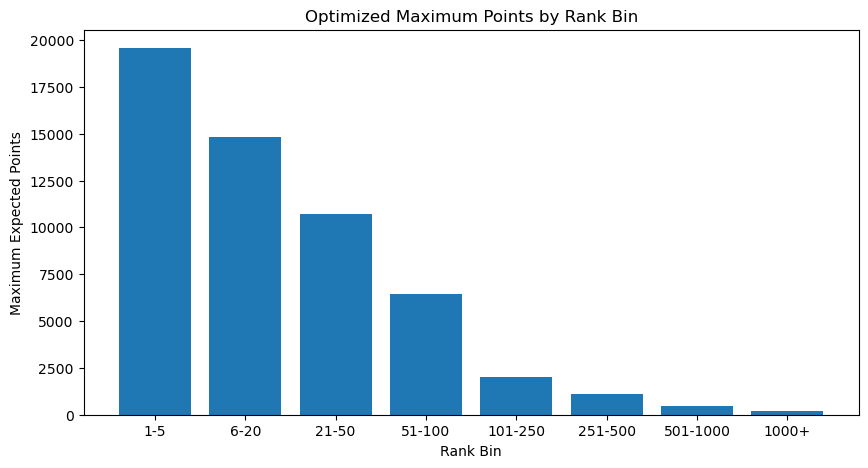

In [40]:
bins = ["1-5", "6-20", "21-50", "51-100","101-250", "251-500", "501-1000", "1000+"]

rank_test_val = [3, 10, 35, 75, 150, 350, 750, 1200]

bin_values = []
for r in rank_test_val:
    val = objective_function(r)
    bin_values.append(val)

plt.figure(figsize=(10,5))
plt.bar(bins, bin_values)
plt.xlabel("Rank Bin")
plt.ylabel("Maximum Expected Points")
plt.title("Optimized Maximum Points by Rank Bin")
plt.show()
